# Detecting Malaria Using PyTorch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

In [3]:
# Loading Images from both Parasitized and Uninfected folders
img_dir=r"C:\Users\madir\OneDrive\Documents\Malaria\cell_images\cell_images"
train_data=datasets.ImageFolder(img_dir, transform=train_transforms )

In [4]:
# Creating Train(70%), Validation(20%) and Test sets(10%) 
val_len=0.2
test_len=0.1
data_len=len(train_data)
indices = list(range(data_len))
np.random.shuffle(indices)
valid_split = int(np.floor((val_len) * data_len))
test_split = int(np.floor((val_len+test_len) * data_len))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [5]:
print(len(valid_idx), len(test_idx), len(train_idx))

5511 2756 19291


In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(train_data,  batch_size=16,
    sampler=test_sampler, num_workers=0)

In [7]:
# Creating a custom convolutional neural network class
class CNN(nn.Module):
    
    def __init__(self,out_dim):
        super(CNN, self).__init__()
        self.model=torch.nn.Sequential()
        self.model.add_module("conv1",torch.nn.Conv2d(3,64,kernel_size=(6,6),stride=(2,2)))
        self.model.add_module("norm1",torch.nn.BatchNorm2d(64))
        self.model.add_module("relu1",torch.nn.ReLU())
        self.model.add_module("max1",torch.nn.MaxPool2d(kernel_size=2,stride=2))
        self.model.add_module("conv2",torch.nn.Conv2d(64,128,kernel_size=(5,5),stride=(2,2)))
        self.model.add_module("norm2",torch.nn.BatchNorm2d(128))
        self.model.add_module("relu2",torch.nn.ReLU())
        self.model.add_module("max2",torch.nn.MaxPool2d(kernel_size=2,stride=2))

        self.fc_model=nn.Sequential(torch.nn.Linear(128*13*13,256),torch.nn.Dropout(0.5),torch.nn.ReLU(),torch.nn.Linear(256,512),torch.nn.Dropout(0.5),torch.nn.ReLU(),torch.nn.Linear(512,out_dim))
        
    def forward(self, x):
        
        x = self.model.forward(x)
        x = x.view(-1, 128*13*13)
        return self.fc_model.forward(x)

In [8]:
# defining train funtion 
def train(model, criterion,optimizer,epochs,train_loader):
    for epoch in range(epochs):
        
        for i,(image,label) in enumerate(train_loader):
            output=model(image)
            loss=criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(loss)
    return loss.item()
    
        

In [9]:
# defining a evalute function that calculates the accuracy of prediction 
def evaluate(model,valid_loader):
    correct=0
    accuracy=0
    N_val=0
    for x_test, y_test in valid_loader:

        z=model(x_test)
        #print(z)
        _,yhat=torch.max(z.data,1)
        correct+=(yhat==y_test).sum().item()
        N_val+=x_test.size(0)
        
    accuracy=correct/N_val*100
    
    return accuracy
    

In [10]:
model = CNN(out_dim=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
# Training the model by calling "train" function
epochs=20
train(model, criterion,optimizer,epochs,train_loader)

tensor(0.5108, grad_fn=<NllLossBackward>)
tensor(0.2875, grad_fn=<NllLossBackward>)
tensor(0.3703, grad_fn=<NllLossBackward>)
tensor(0.3599, grad_fn=<NllLossBackward>)
tensor(0.3601, grad_fn=<NllLossBackward>)
tensor(0.4150, grad_fn=<NllLossBackward>)
tensor(0.2335, grad_fn=<NllLossBackward>)
tensor(0.3842, grad_fn=<NllLossBackward>)
tensor(0.8266, grad_fn=<NllLossBackward>)
tensor(0.3677, grad_fn=<NllLossBackward>)
tensor(0.1576, grad_fn=<NllLossBackward>)
tensor(0.2759, grad_fn=<NllLossBackward>)
tensor(0.2729, grad_fn=<NllLossBackward>)
tensor(0.2831, grad_fn=<NllLossBackward>)
tensor(0.2142, grad_fn=<NllLossBackward>)
tensor(0.2964, grad_fn=<NllLossBackward>)
tensor(0.2186, grad_fn=<NllLossBackward>)
tensor(0.2183, grad_fn=<NllLossBackward>)
tensor(0.4625, grad_fn=<NllLossBackward>)
tensor(0.3748, grad_fn=<NllLossBackward>)


0.3748147785663605

In [12]:
evaluate(model,valid_loader)

85.33841408092904

In [13]:
 evaluate(model,test_loader)

83.88969521044993

In [14]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    
    image = prediction_transform(image)[:,:,:].unsqueeze(0)
    return image

In [15]:
def predict(x_test):
    z=model(x_test)
    print(z)
    _,yhat=torch.max(z.data,1)
    
    return yhat

In [17]:
import os
from glob import glob
from PIL import Image
img_path_p=np.array(glob(os.path.join(img_dir,"Parasitized/*")))
img_path_u=np.array(glob(os.path.join(img_dir,"Uninfected/*")))

tensor([[ 3.0646, -2.5808]], grad_fn=<AddmmBackward>)
Parasitized


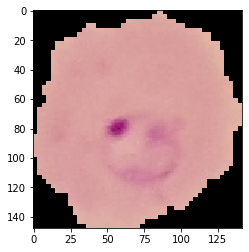

tensor([[ 2.4101, -2.8649]], grad_fn=<AddmmBackward>)
Parasitized


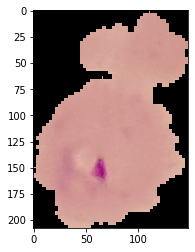

tensor([[ 3.1523, -2.4932]], grad_fn=<AddmmBackward>)
Parasitized


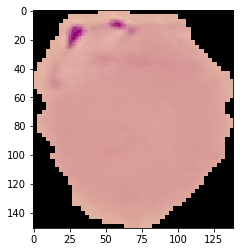

tensor([[ 2.3049, -3.0551]], grad_fn=<AddmmBackward>)
Parasitized


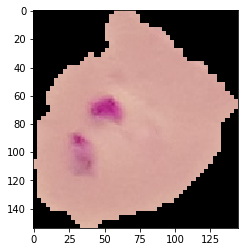

tensor([[ 0.4971, -0.6671]], grad_fn=<AddmmBackward>)
Parasitized


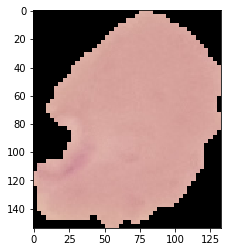

In [18]:
# Looking into prediction for Parasitized class
for i in range(0,5):
    img_path=img_path_p[i]
    img=Image.open(img_path)
    predict_value=predict(load_input_image(img_path))
    if predict_value==0:
        print("Parasitized")
    else:
        print("Uninfected")
    
    plt.imshow(img)
    plt.show()

tensor([[-2.6946,  2.8854]], grad_fn=<AddmmBackward>)
Uninfected


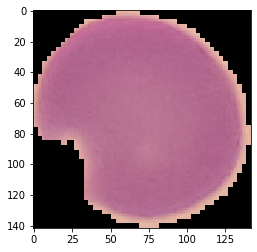

tensor([[ 0.5119, -0.3555]], grad_fn=<AddmmBackward>)
Parasitized


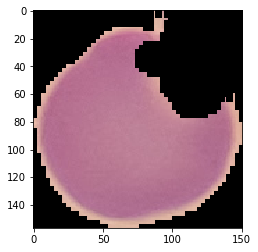

tensor([[-1.0575,  0.9278]], grad_fn=<AddmmBackward>)
Uninfected


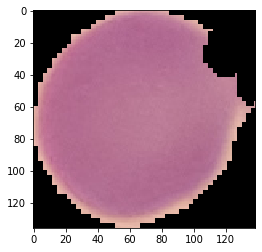

tensor([[-2.4327,  2.2748]], grad_fn=<AddmmBackward>)
Uninfected


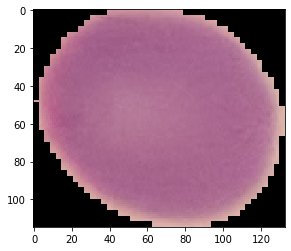

tensor([[-2.0787,  2.0798]], grad_fn=<AddmmBackward>)
Uninfected


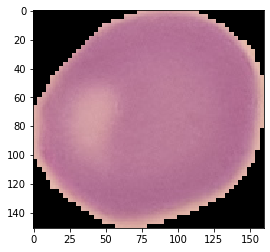

In [19]:
# Looking into prediction for Uninfected class
for i in range(200,205):
    img_path=img_path_u[i]
    img=Image.open(img_path)
    predict_value=predict(load_input_image(img_path))
    if predict_value==0:
        print("Parasitized")
    else:
        print("Uninfected")
    
    plt.imshow(img)
    plt.show()